### 1: Import, Paths and Config

In [2]:
import os
from os import environ

import torch
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate

In [3]:
# Change stevefan to your username
os.chdir('/home/stevefan/bliss/case_studies/weak_lensing/')
environ["BLISS_HOME"] = "/home/stevefan/bliss"

# Compose lensing_config.yaml
with initialize(config_path="../", version_base=None):
    # override the batch size to be 4
    cfg = compose("lensing_config", overrides={"surveys.sdss.load_image_data=true", "prior.batch_size=4"})

### 2: Changes to the prior

Main change is going from comsology -> power spectrum -> shear and convergence maps instead of sampling shear and convergence directly. Currently only passing the following parameters into the prior from lensing_config.yaml:

```
prior:
    _target_: case_studies.weak_lensing.lensing_prior.LensingPrior
    n_tiles_h: 48
    n_tiles_w: 48
    tile_slen: 4
    batch_size: 32
    prob_galaxy: 1.0
    arcsec_per_pixel: 0.396
```

Where arcsec_per_pixel is the ratio we're using to calculate our desired output map length/width in degrees. 

In the prior, we are using pyccl.cosmology.CosmologyVanillaLCDM(), which has the following description from [pyccl](https://ccl.readthedocs.io/en/latest/api/pyccl.cosmology.html#pyccl.cosmology.CosmologyVanillaLCDM):
```
 pyccl.cosmology.CosmologyVanillaLCDM(**kwargs)

A cosmology with typical flat Lambda-CDM parameters (
    Omega_c=0.25,
    Omega_b = 0.05,
    Omega_k = 0,
    sigma8 = 0.81,
    n_s = 0.96,
    h = 0.67,
    no massive neutrinos
) for quick instantiation.
```

We then calculate our ngrid (# of tiles on each side of the output) and grid_size (length/width of output map in real units, like degrees):
```
    ngrid = self.n_tiles_w
    # ngrid is tiles, convert tiles to pixels, then to arcsecs, and then degrees (1 arcsec = 1/3600 degrees)
    grid_size = (ngrid * self.tile_slen * self.arcsec_per_pixel) / 3600
```

Next, we calculate a redshift distribution, which is really just taken from [this notebook](https://github.com/LSSTDESC/CCLX/blob/master/CellsCorrelations.ipynb). We don't quite know if this is a realistic distribution, but our own testing has shown that using different but reasonable distributions didn't affect the shear convergence values too much.

```
    z = np.linspace(0., 3., 512)
    i_lim = 26. # Limiting i-band magnitude
    z0 = 0.0417*i_lim - 0.744

    Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
    pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
    dNdz = Ngal * pz # Number density distribution

    lensing_tracer = ccl.WeakLensingTracer(self.cosmology, dndz=(z, dNdz))
```

Finally, we're calculating the angular cross-power spectrum using the tracer we just declared and using that as the input power spectrum for galsim to figure out the shear and convergence maps. In the demos of pyccl, it looks like their just using the same tracer twice when using angular_cl, so it didn't seem like a big issue. 

```
    # range of values required by buildGrid, currently arbitrarily defined to encapsulate enough valids for buildGrid
    ell = np.arange(1, 100000)

    shear_map = torch.zeros((self.batch_size, self.n_tiles_h, self.n_tiles_w, 2))
    convergence_map = torch.zeros((self.batch_size, self.n_tiles_h, self.n_tiles_w, 1))
    for i in range(self.batch_size):
        cls = ccl.angular_cl(self.cosmology, lensing_tracer, lensing_tracer, ell)
        table = galsim.LookupTable(x = ell, f = cls)
        my_ps = galsim.PowerSpectrum(table, units = galsim.degrees)
        g1, g2, kappa = my_ps.buildGrid(grid_spacing=grid_size/ngrid, ngrid=ngrid,
                                        get_convergence=True, units = galsim.degrees)
        gamma1 = g1 * (1 - kappa)
        gamma2 = g2 * (1 - kappa)

        shear_map[i,:,:,0] = torch.from_numpy(gamma1)
        shear_map[i,:,:,1] = torch.from_numpy(gamma2)
        convergence_map[i,:,:,0] =  torch.from_numpy(kappa)
```

Side Note: we use galsim.degrees for our units above because the notebook with the redshift distribution calculation seemed to use degrees as well. The pyccl documentation wasn't super helpful with what units of angle angular_cl was using. Again, from testing it seems like the units (degrees/radians) didn't affect the shear/convergence values too much, so it didn't seem like too big of a deal.

### 3: Generating images

In [4]:
simulated_dataset = instantiate(cfg.simulator)

# this will get a batch of 4 images, since we've overridden the batch_size in lensing_config.yaml at the top of this file
batch = simulated_dataset.get_batch()
tile_catalogs = batch['tile_catalog']

Here's the r-band of the first few images in the batch (192 pixels by 192 pixels), as well as the corresponding shear1 maps, shear2 maps, and convergence maps (which are all 48 tiles by 48 tiles):


Image # 0:


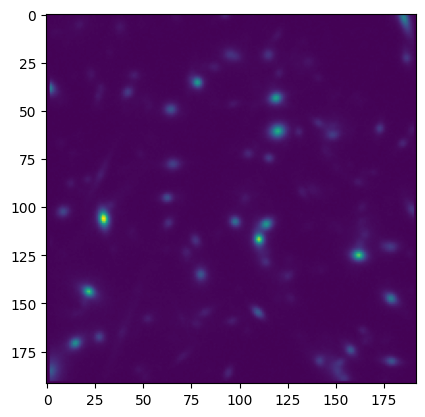

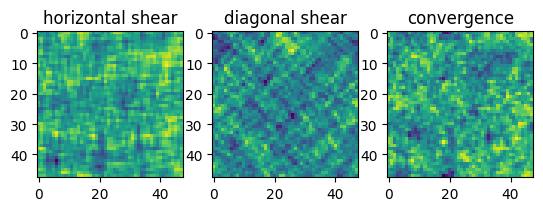

shear1: min = -0.05000000074505806 mean = -0.0 max = 0.03400000184774399
shear2: min = -0.03700000047683716 mean = -0.0 max = 0.03999999910593033
convergence: min = -0.05900000035762787 mean = 0.0 max = 0.04399999976158142

Image # 1:


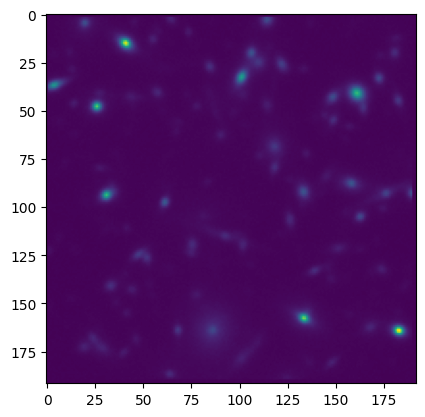

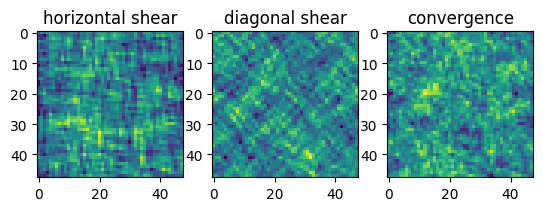

shear1: min = -0.02800000086426735 mean = -0.0 max = 0.03400000184774399
shear2: min = -0.032999999821186066 mean = 0.0 max = 0.03700000047683716
convergence: min = -0.04899999871850014 mean = 0.0 max = 0.04699999839067459

Image # 2:


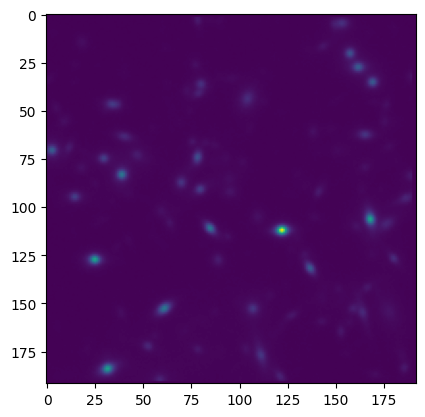

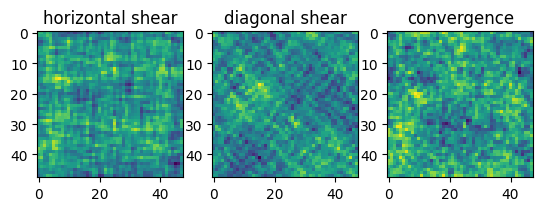

shear1: min = -0.041999999433755875 mean = 0.0 max = 0.03799999877810478
shear2: min = -0.03799999877810478 mean = 0.0 max = 0.04100000113248825
convergence: min = -0.05400000140070915 mean = -0.0 max = 0.04399999976158142

Image # 3:


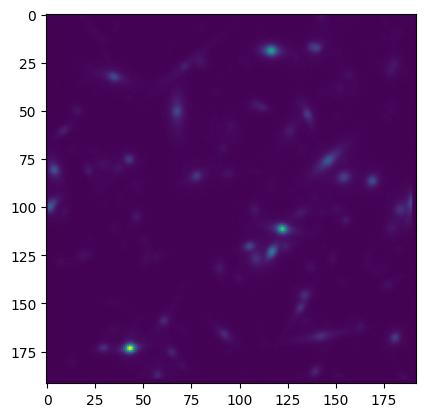

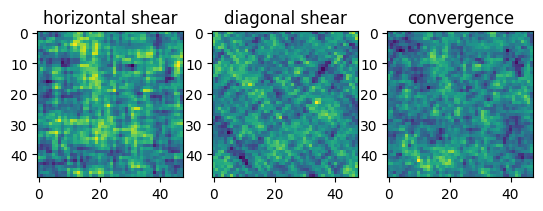

shear1: min = -0.03500000014901161 mean = -0.0 max = 0.03400000184774399
shear2: min = -0.035999998450279236 mean = 0.0 max = 0.03999999910593033
convergence: min = -0.052000001072883606 mean = 0.0 max = 0.06499999761581421


In [22]:
for j in range(4):
    print(f"\nImage # {j}:")

    # r-band
    fig, img = plt.subplots(nrows=1, ncols=1)
    _ = plt.imshow(batch['images'][j][2])
    
    # shear1 (horizontal) map
    fig, (map1, map2, map3) = plt.subplots(nrows=1, ncols=3)
    _ = map1.imshow(tile_catalogs['shear'][j].squeeze()[:,:,0])
    _ = map1.set_title('horizontal shear')

    # shear2 (diagonal) map
    _ = map2.imshow(tile_catalogs['shear'][j].squeeze()[:,:,1])
    _ = map2.set_title('diagonal shear')

    # convergence map
    _ = map3.imshow(tile_catalogs['convergence'][j].squeeze())
    _ = map3.set_title('convergence')

    plt.show()

    gamma1 = tile_catalogs['shear'][j].squeeze()[:,:,0].numpy()
    gamma2 = tile_catalogs['shear'][j].squeeze()[:,:,1].numpy()
    kappa = tile_catalogs['convergence'][j].squeeze().numpy()

    print('shear1:', f'min = {gamma1.min().round(3)}', f'mean = {gamma1.mean().round(3)}', f'max = {gamma1.max().round(3)}')
    print('shear2:', f'min = {gamma2.min().round(3)}', f'mean = {gamma2.mean().round(3)}', f'max = {gamma2.max().round(3)}')
    print('convergence:', f'min = {kappa.min().round(3)}', f'mean = {kappa.mean().round(3)}', f'max = {kappa.max().round(3)}')